<a href="https://colab.research.google.com/github/ayuko66/akiya-lens/blob/model_accuracy/notebook/akiya_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Task
Load the data from "/content/drive/MyDrive/Colab Notebooks/ml_projects/akiya-lens/features_master__wide__v1.csv", define the columns '2018_出生率[‰]', '2018_年少人口率[%]', '2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入超過率[‰]', '2018_高齢化率[%]', '2023_出生率[‰]', '2023_年少人口率[%]', '2023_死亡率[‰]', '2023_生産年齢人口率[%]', '2023_転入超過率[‰]', '2023_高齢化率[%]', 'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度', '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '学校密度[件/km²]', '2023年総人口あたりの学校密度', '平均気温', '年最深積雪', '年降水量', '病院密度[件/km²]', '2023年総人口あたりの病院密度', '駅密度[件/km²]', '2023年総人口あたりの駅密度' as features and '空き家率_2023' as the target variable. Predict the target variable using LightGBM with cross-validation for splitting the data into training and testing sets. Visualize the model interpretation using SHAP.

## データ読み込み



In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ml_projects/akiya-lens/features_master__wide__v1.csv")
display(df.head())

,市区町村コード,市区町村名,都道府県名,2018_15〜64歳人口,2018_15歳未満人口,2018_65歳以上人口,2018_出生数,2018_出生率[‰],2018_年少人口率[%],2018_死亡数,...,2023_転入者数,2023_転出者数,2023_高齢化率[%],2023_年少人口率[%],2023_生産年齢人口率[%],2023_出生率[‰],2023_死亡率[‰],2023_転入率[‰],2023_転出率[‰],2023_転入超過率[‰]
0,15100,新潟市,新潟県,474664.0,96925.0,225184.0,NaN,NaN,12.164694,NaN,...,26679.0,27252.0,29.982440,11.726587,58.290973,NaN,NaN,34.220825,34.955805,-0.734980
1,15101,北区,新潟県,44081.0,9034.0,22055.0,443.0,5.893309,12.018092,837.0,...,1881.0,2120.0,31.995530,11.446980,56.557490,4.828785,14.031070,25.951271,29.248641,-3.297370
2,15102,東区,新潟県,82565.0,16847.0,38400.0,1091.0,7.916582,12.224625,1466.0,...,4360.0,4806.0,29.473246,11.676157,58.850597,5.909814,13.849036,32.411055,35.726498,-3.315443
3,15103,中央区,新潟県,109398.0,20897.0,46330.0,1382.0,7.824487,11.831281,1995.0,...,9175.0,9056.0,27.132032,11.375431,61.492537,6.303100,12.456946,52.669346,51.986223,0.683123
4,15104,江南区,新潟県,40429.0,9022.0,19622.0,508.0,7.354538,13.061544,826.0,...,2199.0,2259.0,29.937593,12.734757,57.327649,6.592248,13.653277,32.214116,33.093083,-0.878966


In [4]:
features = [
    '2018_出生率[‰]', '2018_年少人口率[%]', '2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入超過率[‰]',
    '2018_高齢化率[%]', '2023_出生率[‰]', '2023_年少人口率[%]', '2023_死亡率[‰]', '2023_生産年齢人口率[%]',
    '2023_転入超過率[‰]', '2023_高齢化率[%]', 'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度',
    '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '学校密度[件/km²]', '2023年総人口あたりの学校密度',
    '平均気温', '年最深積雪', '年降水量', '病院密度[件/km²]', '2023年総人口あたりの病院密度',
    '駅密度[件/km²]', '2023年総人口あたりの駅密度', '空き家率_2018'
]
target = '空き家率_2023'

X = df[features]
y = df[target]

In [5]:
for col in ['駅密度[件/km²]', '病院密度[件/km²]', '学校密度[件/km²]', 'スーパー密度[件/km²]']:
    X[col+'_isna'] = X[col].isna().astype(int)

/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col+'_isna'] = X[col].isna().astype(int)
/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col+'_isna'] = X[col].isna().astype(int)
/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [6]:
X.head(10)

,2018_出生率[‰],2018_年少人口率[%],2018_死亡率[‰],2018_生産年齢人口率[%],2018_転入超過率[‰],2018_高齢化率[%],2023_出生率[‰],2023_年少人口率[%],2023_死亡率[‰],2023_生産年齢人口率[%],...,年降水量,病院密度[件/km²],2023年総人口あたりの病院密度,駅密度[件/km²],2023年総人口あたりの駅密度,空き家率_2018,駅密度[件/km²]_isna,病院密度[件/km²]_isna,学校密度[件/km²]_isna,スーパー密度[件/km²]_isna
0,NaN,12.164694,NaN,59.573304,-0.696560,28.262002,NaN,11.726587,NaN,58.290973,...,NaN,0.020144,0.000059,0.016641,0.000049,12.9446,0,0,0,0
1,5.893309,12.018092,11.134761,58.641745,-4.403352,29.340162,4.828785,11.446980,14.031070,56.557490,...,NaN,NaN,NaN,NaN,NaN,9.3668,1,1,1,1
2,7.916582,12.224625,10.637680,59.911328,-0.493426,27.864047,5.909814,11.676157,13.849036,58.850597,...,NaN,NaN,NaN,NaN,NaN,12.7208,1,1,1,1
3,7.824487,11.831281,11.295117,61.938004,-0.951168,26.230715,6.303100,11.375431,12.456946,61.492537,...,1780.6,0.096350,0.000098,0.039673,0.000040,16.9009,0,0,0,0
4,7.354538,13.061544,11.958363,58.530830,2.215048,28.407627,6.592248,12.734757,13.653277,57.327649,...,NaN,NaN,NaN,NaN,NaN,7.4002,1,1,1,1
5,6.696083,12.468390,12.385818,57.187645,1.238582,30.343964,5.175138,11.975244,14.353437,55.949434,...,NaN,NaN,NaN,NaN,NaN,11.1401,1,1,1,1
6,6.483769,11.811927,11.798694,60.047636,-4.300459,28.140438,4.664629,11.429491,14.522393,57.549576,...,NaN,NaN,NaN,NaN,NaN,10.9404,1,1,1,1
7,7.205271,12.586012,10.416799,59.099755,1.850604,28.314234,5.820939,12.350541,13.222397,57.856019,...,1765.5,0.013827,0.000039,0.020740,0.000058,12.5517,0,0,0,0
8,5.155617,10.887145,13.725321,58.118803,-5.741874,30.994051,4.251222,10.206566,15.478807,55.314936,...,1794.4,0.000000,0.000000,0.005588,0.000055,10.9981,0,0,0,0
9,6.791171,12.250454,12.909080,57.923277,-2.575962,29.826269,5.429837,11.621443,14.901717,56.799809,...,2578.7,0.004541,0.000019,0.015438,0.000064,12.5901,0,0,0,0


In [7]:
isna_cols = ['駅密度[件/km²]_isna', '病院密度[件/km²]_isna', '学校密度[件/km²]_isna', 'スーパー密度[件/km²]_isna']
for col in isna_cols:
    if col in X.columns:
        proportion_of_ones = X[col].mean() * 100
        print(f"{col} の '1' の割合: {proportion_of_ones:.2f}%")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame X.")

駅密度[件/km²]_isna の '1' の割合: 8.44%
病院密度[件/km²]_isna の '1' の割合: 8.44%
学校密度[件/km²]_isna の '1' の割合: 8.44%
スーパー密度[件/km²]_isna の '1' の割合: 8.44%


In [8]:
df['OSM_missing'] = df[['駅密度[件/km²]', 'スーパー密度[件/km²]',
                     '病院密度[件/km²]', '学校密度[件/km²]']].isna().all(axis=1).astype(int)

## 交差検証のためのデータ分割

学習データとテストデータを交差検証用に分割します。


In [9]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = list(kf.split(X))

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

models = []
oof_predictions = np.zeros(len(df))


# Function to sanitize feature names
def sanitize_feature_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Drop the isna_cols before sanitizing
isna_cols = ['駅密度[件/km²]_isna', '病院密度[件/km²]_isna', '学校密度[件/km²]_isna', 'スーパー密度[件/km²]_isna']
X = X.drop(columns=isna_cols, errors='ignore')


X_sanitized = sanitize_feature_names(X.copy())
feature_importances = pd.DataFrame(index=X_sanitized.columns)


for fold, (train_index, test_index) in enumerate(fold_indices):
    print(f"Fold {fold+1}/{kf.n_splits}")
    X_train, X_test = X_sanitized.iloc[train_index], X_sanitized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42 + fold,
        'boosting_type': 'gbdt',
    }

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])

    models.append(model)
    oof_predictions[test_index] = model.predict(X_test)
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_

rmse = np.sqrt(mean_squared_error(y, oof_predictions))
print(f"\nOverall RMSE: {rmse}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Overall RMSE: 6.220400956158274


In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'oof_predictions' contains the out-of-fold predictions from the previous step
# And 'y' contains the true target values

rmse = np.sqrt(mean_squared_error(y, oof_predictions))
r2 = r2_score(y, oof_predictions)

print(f"Overall RMSE: {rmse}")
print(f"Overall R-squared: {r2}")

Overall RMSE: 6.220400956158274
Overall R-squared: 0.3590521819871052


In [12]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 1s (8,481 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.fontManager.addfont('/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf')
plt.rcParams['font.family'] = 'IPAPGothic'

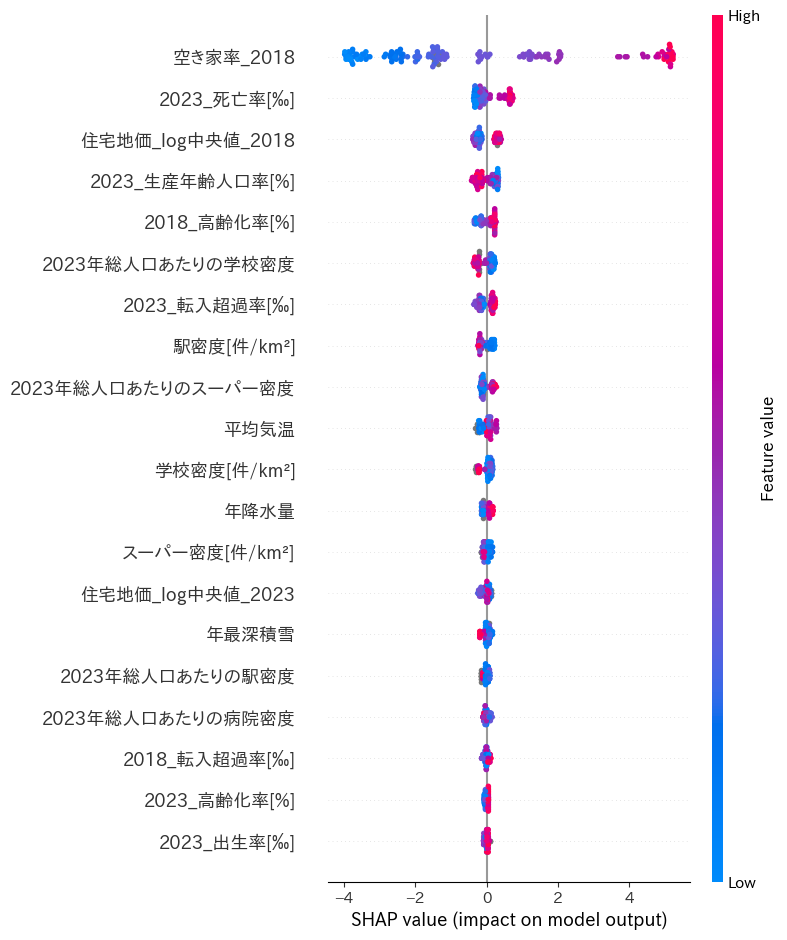

In [14]:
# Install shap if not already installed
!pip install shap

import shap

# Use the first trained model for SHAP explanation
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_sanitized)

# Visualize the SHAP results (summary plot)
shap.summary_plot(shap_values, X_sanitized, feature_names=X.columns)

これで日本語が表示されるはずです。SHAPのプロットを再度実行してみてください。

## 各市区町村の空き家率の期待値 (予測値)

各市区町村について、モデルが予測した空き家率の期待値（予測値）を表示

In [15]:
df_with_predictions = df.copy()
df_with_predictions['predicted_空き家率_2023'] = oof_predictions

display(df_with_predictions[['市区町村名', '空き家率_2023', 'predicted_空き家率_2023']].head())

,市区町村名,空き家率_2023,predicted_空き家率_2023
0,新潟市,13.12,12.877446
1,北区,9.49,10.722924
2,東区,12.61,12.309627
3,中央区,16.36,17.264778
4,江南区,9.22,11.893079


## 実際の空き家率と予測された空き家率の比較

実際の空き家率とモデルが予測した空き家率を散布図で比較

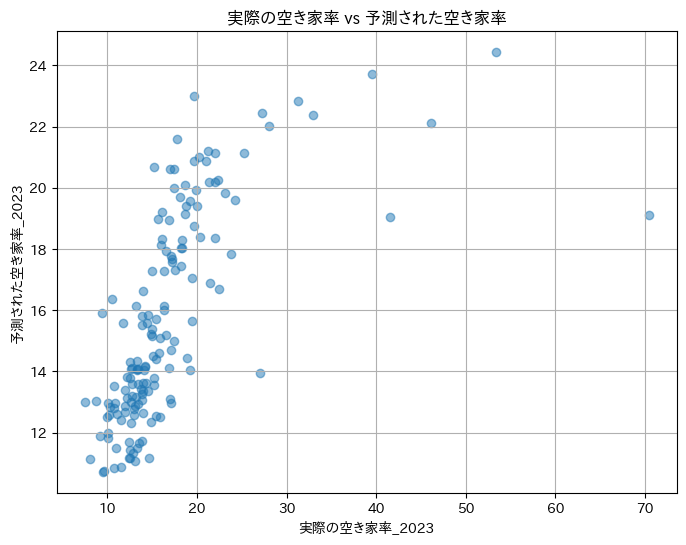

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y, oof_predictions, alpha=0.5)
plt.xlabel("実際の空き家率_2023")
plt.ylabel("予測された空き家率_2023")
plt.title("実際の空き家率 vs 予測された空き家率")
plt.grid(True)
plt.show()

In [17]:
# Install CatBoost if not already installed
!pip install catboost

import numpy as np # Import numpy
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold # Import KFold as it's used
from sklearn.metrics import mean_squared_error, r2_score # Import metrics

# Perform cross-validation and model training with CatBoost
catboost_models = []
oof_predictions_catboost = np.zeros(len(df))

kf_catboost = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices_catboost = list(kf_catboost.split(X_sanitized))


for fold, (train_index, test_index) in enumerate(fold_indices_catboost):
    print(f"Fold {fold+1}/{kf_catboost.n_splits}")
    X_train, X_test = X_sanitized.iloc[train_index], X_sanitized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    catboost_params = {
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': 0, # Set to True for verbose output
        'random_seed': 42 + fold,
        'allow_writing_files': False # Disable writing files
    }

    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=100)

    catboost_models.append(model)
    oof_predictions_catboost[test_index] = model.predict(X_test)


rmse_catboost = np.sqrt(mean_squared_error(y, oof_predictions_catboost))
r2_catboost = r2_score(y, oof_predictions_catboost)


print(f"\n--- CatBoost Results ---")
print(f"Overall RMSE: {rmse_catboost}")
print(f"Overall R-squared: {r2_catboost}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

--- CatBoost Results ---
Overall RMSE: 5.23672598264191
Overall R-squared: 0.5457388315883798


## CatBoostモデルのSHAPによる解釈の可視化

### Subtask:
CatBoostモデルのSHAP値を計算し、サマリープロットで可視化します。

**Reasoning**:
Calculate SHAP values for the CatBoost model and generate a summary plot to visualize feature importances and their impact on the predictions.

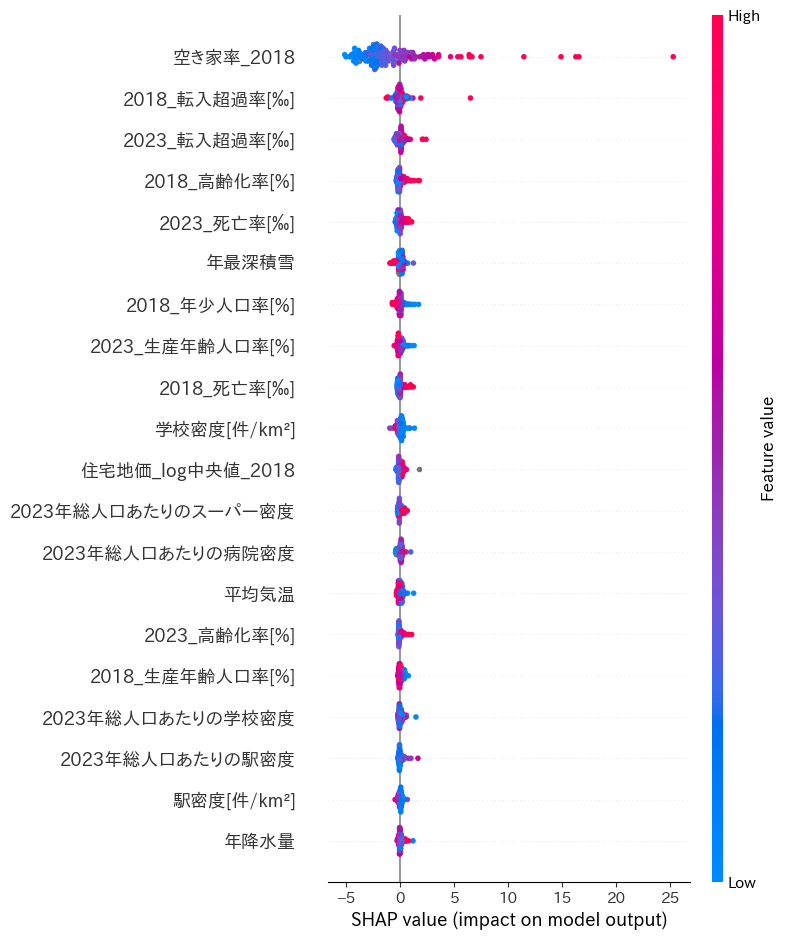

In [19]:
import shap

# Use the first trained CatBoost model for SHAP explanation
explainer_catboost = shap.TreeExplainer(catboost_models[0])
shap_values_catboost = explainer_catboost.shap_values(X_sanitized)

# Visualize the SHAP results (summary plot) for CatBoost
shap.summary_plot(shap_values_catboost, X_sanitized, feature_names=X.columns)